#### I have taken permission from the professor for late submission. Please don't cut marks for late submission. Thanks.

### Part 1 - Creating Database

In [39]:
#Importing Dependiencies
%matplotlib inline
import wave
import contextlib
import os
import librosa
import itertools
import pandas as pd
import seaborn as sns
import time
import numpy as np
import python_speech_features
from scipy.io.wavfile import read
import scipy.io.wavfile
from scipy.fftpack import dct
from nltk.tokenize import RegexpTokenizer
import random
import numpy as np
import numpy

Objective: To create a speech recognizer by implementing googles algorithm of LAS (Listen, Attend and Spell) Deep Learning Model. 

The Database will be a pandas dataframe as of now which will be extended to spark RDDs later as the data for the manuplation grows in size.

Initially the data is downloaded from Vox Forge Repository (http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/) to the local machine and operations will be done of the downloaded directory of file to curate a database in form of pandas dataframe.

Following attributes will be included in the dataframe after curation of data:

* Audio_ID (unique ID corrosponding to each audio file)
* Audio_Prompt (prompt corrosponding to each audio file)
* Audio_Path (path where each audio file is saved on the local machine or cloud)
* Audio_Length (Length of each audio clip)
* MFCC (These are the audio features which will be used as input to neural network models)
         Specification of MFCCs: 40-dimensional MFCC frames were computed for every 10 ms, and then zero- padded to 800 frames (8 sec)
* Predicted audio transcript
* Letter wise accuracy of predicted audio transcript
* Word wise accuracy of predicted audio transcript
* Accuracy of generated trascript according to model accuracy matrics

NOTE: I am just using part of my data to show workflow right now, orignal data is very big and computation will be done on the cloud, that's why whole data is not being used.

In [7]:
#Generating list of folders in the downloaded data 
list_of_folders = []
for i in os.listdir(str(os.getcwd()) + "/Data_Part_Project"):
    list_of_folders.append(i)

list_of_folders

['.DS_Store',
 '1028-20100710-hne',
 '1337ad-20170321-ajg',
 '1337ad-20170321-tkg',
 '1337ad-20170321-ynk',
 '1snoke-20120412-hge',
 '23yipikaye-20100807-ujm',
 '2old2play-20110606-hcn',
 '2old2play-20110606-wlt',
 '314piwm-20130617-xuo',
 '_caustic_-20170306-smy',
 '_r2h-20100822-kmh',
 'aaa-20150128-fak',
 'aahz-20100418-xhv',
 'Aaron-20080318-kdl',
 'Aaron-20080318-lbb',
 'Aaron-20080318-lbk',
 'Aaron-20080318-liy',
 'Aaron-20080318-ngh',
 'Aaron-20080318-pwn',
 'Aaron-20130527-giy',
 'abc-20091120-mfr',
 'abdelrahman-20100816-pvz',
 'AbdulMoiz-20121010-juf',
 'abhishek-20120110-qdn',
 'ablackball-20121113-lxs',
 'ablackball-20121113-vvk',
 'ackermann-20101216-bpv',
 'ada-20090105-axq',
 'adamvan2000-20090911-njp',
 'adgar-20091227-ell',
 'Adminvox-05232006',
 'Adminvox-05262006',
 'AdrianMcNear-20091016-psv',
 'adubra-20090703-zxu',
 'ae-20100821-aov',
 'ae-20100821-xop',
 'Afshad-20090813-zcz',
 'Afzal-20110524-qsu',
 'aglehg-20130430-nvw',
 'ahbigalex10-20090529-owx',
 'aiden11-2

In [8]:
#A look at how the directory tree looks for each folder in the downloaded data
for path, dirs, files in os.walk(str(os.getcwd()) +"/Data_Part_Project/1snoke-20120412-hge"):
    print (path)
    for f in files:
        print (f)


/Users/Gurtej/Desktop/Data_Part_Project/1snoke-20120412-hge
.DS_Store
LICENSE
/Users/Gurtej/Desktop/Data_Part_Project/1snoke-20120412-hge/etc
GPL_license.txt
HDMan_log
HVite_log
Julius_log
PROMPTS
prompts-original
README
/Users/Gurtej/Desktop/Data_Part_Project/1snoke-20120412-hge/wav
a0405.wav
a0406.wav
a0407.wav
a0408.wav
a0409.wav
a0410.wav
a0411.wav
a0412.wav
a0413.wav
a0414.wav


By observing the directory tree, we see that the wav (audio files) are saved within folder called wav that exist in each data folder. The prompts corrosponding to each folder are stored in "etc" folder by name "prompts-orignal" which is there in each data folder. 

In [9]:
#Let's see how the prompt file looks
open(str(os.getcwd()) + "/Data_Part_Project/1snoke-20120412-hge/etc/prompts-original").readlines()

['a0405 It seemed the ordained order of things that dogs should work. \n',
 'a0406 And that was the last of Francois and Perrault. \n',
 'a0407 Mercedes screamed, cried, laughed, and manifested the chaotic abandonment of hysteria. \n',
 'a0408 The Eldorado emptied its occupants into the street to see the test. \n',
 'a0409 He could feel a new stir in the land. \n',
 'a0410 So we have to fit the boat throughout with oil lamps as well. \n',
 'a0411 It will break our hearts and our backs to hoist anchor by hand. \n',
 'a0412 There is another virtue in these bulkheads. \n',
 'a0413 But I am at the end of my resources. \n',
 'a0414 Now our figuring was all right. \n']

So as we see each line in the file corrosponds to the prompt corrospinding to each audio file in the each data file.

In [10]:
list_of_folders.remove(".DS_Store")

In [11]:
#Making a single list of all wave files in all the datafolders
wav_files = []
for folder in list_of_folders:
    wav_files.append(os.listdir(str(os.getcwd()) + "/Data_Part_Project/" + folder + "/wav"))

In [12]:
#We have a list of list corrosponding to each wav file, let's convert it into a single list
wav_files

[['ar-01.wav',
  'ar-02.wav',
  'ar-03.wav',
  'ar-04.wav',
  'ar-05.wav',
  'ar-06.wav',
  'ar-07.wav',
  'rp-29.wav',
  'rp-30.wav',
  'rp-31.wav'],
 ['en-0532.wav',
  'en-0533.wav',
  'en-0534.wav',
  'en-0535.wav',
  'en-0536.wav',
  'en-0537.wav',
  'en-0538.wav',
  'en-0539.wav',
  'en-0540.wav',
  'en-0541.wav'],
 ['en-0726.wav',
  'en-0727.wav',
  'en-0728.wav',
  'en-0729.wav',
  'en-0730.wav',
  'en-0731.wav',
  'en-0732.wav',
  'en-0733.wav',
  'en-0734.wav',
  'en-0735.wav'],
 ['en-0647.wav',
  'en-0648.wav',
  'en-0649.wav',
  'en-0650.wav',
  'en-0651.wav',
  'en-0652.wav',
  'en-0653.wav',
  'en-0654.wav',
  'en-0655.wav',
  'en-0656.wav'],
 ['a0405.wav',
  'a0406.wav',
  'a0407.wav',
  'a0408.wav',
  'a0409.wav',
  'a0410.wav',
  'a0411.wav',
  'a0412.wav',
  'a0413.wav',
  'a0414.wav'],
 ['b0312.wav',
  'b0313.wav',
  'b0314.wav',
  'b0315.wav',
  'b0316.wav',
  'b0317.wav',
  'b0318.wav',
  'b0319.wav',
  'b0320.wav',
  'b0321.wav'],
 ['a0293.wav',
  'a0294.wav',
  'a

In [13]:
#Making a single list for all wav files
wav_files_all = [j for i in wav_files for j in i]
wav_files_all

['ar-01.wav',
 'ar-02.wav',
 'ar-03.wav',
 'ar-04.wav',
 'ar-05.wav',
 'ar-06.wav',
 'ar-07.wav',
 'rp-29.wav',
 'rp-30.wav',
 'rp-31.wav',
 'en-0532.wav',
 'en-0533.wav',
 'en-0534.wav',
 'en-0535.wav',
 'en-0536.wav',
 'en-0537.wav',
 'en-0538.wav',
 'en-0539.wav',
 'en-0540.wav',
 'en-0541.wav',
 'en-0726.wav',
 'en-0727.wav',
 'en-0728.wav',
 'en-0729.wav',
 'en-0730.wav',
 'en-0731.wav',
 'en-0732.wav',
 'en-0733.wav',
 'en-0734.wav',
 'en-0735.wav',
 'en-0647.wav',
 'en-0648.wav',
 'en-0649.wav',
 'en-0650.wav',
 'en-0651.wav',
 'en-0652.wav',
 'en-0653.wav',
 'en-0654.wav',
 'en-0655.wav',
 'en-0656.wav',
 'a0405.wav',
 'a0406.wav',
 'a0407.wav',
 'a0408.wav',
 'a0409.wav',
 'a0410.wav',
 'a0411.wav',
 'a0412.wav',
 'a0413.wav',
 'a0414.wav',
 'b0312.wav',
 'b0313.wav',
 'b0314.wav',
 'b0315.wav',
 'b0316.wav',
 'b0317.wav',
 'b0318.wav',
 'b0319.wav',
 'b0320.wav',
 'b0321.wav',
 'a0293.wav',
 'a0294.wav',
 'a0295.wav',
 'a0296.wav',
 'a0297.wav',
 'a0298.wav',
 'a0299.wav',
 '

In [14]:
wav_files_all.remove(".DS_Store")

In [15]:
#Creating a single list of all prompts corrosponding to the audio_id
prompt_list = []
for prompts in list_of_folders:
    prompt_list.append(str(os.getcwd()) + "/Data_Part_Project/" + prompts + "/etc/prompts-original")

prompt_list[:5]

['/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/etc/prompts-original',
 '/Users/Gurtej/Desktop/Data_Part_Project/1337ad-20170321-ajg/etc/prompts-original',
 '/Users/Gurtej/Desktop/Data_Part_Project/1337ad-20170321-tkg/etc/prompts-original',
 '/Users/Gurtej/Desktop/Data_Part_Project/1337ad-20170321-ynk/etc/prompts-original',
 '/Users/Gurtej/Desktop/Data_Part_Project/1snoke-20120412-hge/etc/prompts-original']

In [16]:
#Reading all the lines in each prompt file
lines_prompt = []
for lines in prompt_list:
    lines_prompt.append(open(lines).readlines())
lines_prompt

[['ar-01 Once there was a young rat named Arthur who never could make up his mind. \n',
  'ar-02 Whenever his friends asked him if he would like to go out with them, \n',
  'ar-03 he would only answer, "I don\'t know;" he wouldn\'t say yes or no either. \n',
  'ar-04 He would always shirk making a choice. His Aunt Helen said to him, \n',
  'ar-05 "Now look here! No one is going to care for you if you carry on like this." \n',
  'ar-06 You have no more mind than a blade of grass. \n',
  'ar-07 One rainy day the rats heard a great noise in the loft. \n',
  'rp-29 since red and green light when mixed form yellow. \n',
  'rp-30 This is a very common type of bow, one showing mainly red and yellow, \n',
  'rp-31 with little or no green or blue.\n'],
 ['en-0532 This will be discussed with industry \n',
  'en-0533 through a series of informal outreach sessions over the next few months \n',
  'en-0534 Here the classes are total immersion \n',
  'en-0535 so that he is in with children from a var

In [17]:
#Converting the list of list of prompts into a single list
lines_prompt_all = [j for i in lines_prompt for j in i]
lines_prompt_all

['ar-01 Once there was a young rat named Arthur who never could make up his mind. \n',
 'ar-02 Whenever his friends asked him if he would like to go out with them, \n',
 'ar-03 he would only answer, "I don\'t know;" he wouldn\'t say yes or no either. \n',
 'ar-04 He would always shirk making a choice. His Aunt Helen said to him, \n',
 'ar-05 "Now look here! No one is going to care for you if you carry on like this." \n',
 'ar-06 You have no more mind than a blade of grass. \n',
 'ar-07 One rainy day the rats heard a great noise in the loft. \n',
 'rp-29 since red and green light when mixed form yellow. \n',
 'rp-30 This is a very common type of bow, one showing mainly red and yellow, \n',
 'rp-31 with little or no green or blue.\n',
 'en-0532 This will be discussed with industry \n',
 'en-0533 through a series of informal outreach sessions over the next few months \n',
 'en-0534 Here the classes are total immersion \n',
 'en-0535 so that he is in with children from a variety of cultura

In [18]:
#Creating path for each wav file, which will be useful at later for different functions
wav_file_path = []
for i in list_of_folders:
    for j in os.listdir(str(os.getcwd()) + "/Data_Part_Project/" + i +"/wav"):
        wav_file_path.append(str(os.getcwd()) +"/Data_Part_Project/" + i +"/wav/" +j )

wav_file_path[:10]

['/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-01.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-02.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-03.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-04.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-05.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-06.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/ar-07.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/rp-29.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/rp-30.wav',
 '/Users/Gurtej/Desktop/Data_Part_Project/1028-20100710-hne/wav/rp-31.wav']

In [19]:
wav_file_path.remove('/Users/Gurtej/Desktop/Data_Part_Project/aileen-20080831-ema/wav/.DS_Store')

Now we will combine the Audio_ID, Audio_Prompt and Audio_Path to create first initial pandas dataframe which will be used as our database

In [20]:
#Creating the initial database
Database = [('Audio_ID', wav_files_all),
         ('Audio_Prompt', lines_prompt_all),
         ('Audio_Path', wav_file_path)
         ]
Database = pd.DataFrame.from_items(Database)

In [21]:
Database.head(15)

,Audio_ID,Audio_Prompt,Audio_Path
0,ar-01.wav,ar-01 Once there was a young rat named Arthur ...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
1,ar-02.wav,ar-02 Whenever his friends asked him if he wou...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
2,ar-03.wav,"ar-03 he would only answer, ""I don't know;"" he...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
3,ar-04.wav,ar-04 He would always shirk making a choice. H...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
4,ar-05.wav,"ar-05 ""Now look here! No one is going to care ...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
5,ar-06.wav,ar-06 You have no more mind than a blade of gr...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
6,ar-07.wav,ar-07 One rainy day the rats heard a great noi...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
7,rp-29.wav,rp-29 since red and green light when mixed for...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
8,rp-30.wav,"rp-30 This is a very common type of bow, one s...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...
9,rp-31.wav,rp-31 with little or no green or blue.\n,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...


In [22]:
#Function to calulate length of the inpute wave 
def audio_length(audiofile):
    with contextlib.closing(wave.open(audiofile,'r')) as f: 
        frames = f.getnframes()
        rate = f.getframerate()
        length = frames / float(rate)    
        return length


In [23]:
#calculating time of each audio file
audio_time = []
for file in wav_file_path:
    audio_time.append(audio_length(file))

In [24]:
Database["Audio_Time"] = audio_time
Database.head(5)

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time
0,ar-01.wav,ar-01 Once there was a young rat named Arthur ...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.250
1,ar-02.wav,ar-02 Whenever his friends asked him if he wou...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375
2,ar-03.wav,"ar-03 he would only answer, ""I don't know;"" he...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.500
3,ar-04.wav,ar-04 He would always shirk making a choice. H...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.875
4,ar-05.wav,"ar-05 ""Now look here! No one is going to care ...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.625


Now as per the paper (https://web.stanford.edu/class/cs224n/reports/2761080.pdf), for each audio file we have to compute 40 Dimensional MFCC frames for every 10ms, zero padded to 800 frames (8 secs). All audio files greater than 8 seconds will be removed.

### Database Query Question 1

Question_1: Percentage of data that we are going to discard because length is of audio file is greater than 8 secs

In [25]:
#Number of queries greather than 8 secs
len(Database[(Database["Audio_Time"] > 8.0)])

42

In [26]:
#Percentage of data we are going to discard
len(Database[(Database["Audio_Time"] > 8.0)])/len(Database)

0.07879924953095685

In [27]:
#Time requried by the query
start = time.time()
len(Database[(Database["Audio_Time"] > 8.0)])/len(Database)
print ("Time requried by the query is" + " " + str(time.time() - start) + " secs")

Time requried by the query is 0.0010890960693359375 secs


In [28]:
#Removing all the audio files with length greater than 8 secs
Database = Database[Database.Audio_Time <= 8]
len(Database)

491

### Database Query question 2

Question_2: Distribution of audio time after removing all audios greater than 8 secs and what is most frequently occouring audio length

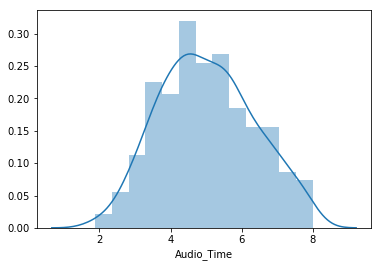

In [29]:
sns.distplot(Database.Audio_Time)

The distribution looks almost normal with most audio clips occuring near 5 secs. Let's query database to see it.

In [30]:
Database.groupby(pd.cut(Database['Audio_Time'], np.arange(0,10,1))).count()

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time
Audio_Time,,,,
"(0, 1]",0,0,0,0
"(1, 2]",3,3,3,3
"(2, 3]",25,25,25,25
"(3, 4]",94,94,94,94
"(4, 5]",128,128,128,128
"(5, 6]",131,131,131,131
"(6, 7]",73,73,73,73
"(7, 8]",37,37,37,37
"(8, 9]",0,0,0,0


From above we see that there are 125 file between 4-5 secs and 138 between 5-6 secs. So majority of the files can be considered to be between 5 secs.

In [31]:
#Time requried by the query
start = time.time()
Database.groupby(pd.cut(Database['Audio_Time'], np.arange(0,10,1))).count()
print ("Time requried by the query is" + " " + str(time.time() - start) + " secs")

Time requried by the query is 0.008595943450927734 secs


In [41]:
#Function foe calculating MFCCs for audio files as described above
def mfcc(Audio_File):

    sample_rate, signal = scipy.io.wavfile.read(Audio_File)  # File assumed to be in the same directory
    signal = signal[0:int(8 * sample_rate)]  # Keep the first 3.5 seconds

    pre_emphasis = 0.97

    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    frame_size = 0.025
    frame_stride = 0.01

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]

    frames *= numpy.hamming(frame_length)

    NFFT = 512

    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    nfilt = 40 

    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB

    num_ceps = 12

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps + 1)] # Keep 2-13
    
    return mfcc

In [42]:
#Now we will calculate MFCC for each audio file and add it to Database Dataframe
Audio_MFCC = []
for path in Database["Audio_Path"]:
    Audio_MFCC.append(mfcc(path))

In [43]:
Database["Audio_MFCC"] = Audio_MFCC

In [44]:
Database.head(19)

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time,Audio_MFCC
0,ar-01.wav,ar-01 Once there was a young rat named Arthur ...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.250,"[[-71.4027789207, 16.6506328869, 7.90910317203..."
1,ar-02.wav,ar-02 Whenever his friends asked him if he wou...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375,"[[-67.8487102654, 5.48487660143, -6.8639734958..."
2,ar-03.wav,"ar-03 he would only answer, ""I don't know;"" he...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.500,"[[-56.1370403534, 0.917676509435, -22.61451455..."
3,ar-04.wav,ar-04 He would always shirk making a choice. H...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.875,"[[-64.2758692913, 4.54850120146, -18.806625193..."
4,ar-05.wav,"ar-05 ""Now look here! No one is going to care ...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.625,"[[-42.9130282419, 18.4081023001, 12.3510009152..."
5,ar-06.wav,ar-06 You have no more mind than a blade of gr...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,4.500,"[[-45.2064146321, 19.3503254482, 8.54280094932..."
6,ar-07.wav,ar-07 One rainy day the rats heard a great noi...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375,"[[-75.041533707, 0.761466980756, -5.1607832218..."
7,rp-29.wav,rp-29 since red and green light when mixed for...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.125,"[[-80.9845757777, -4.08334894332, -5.545150627..."
8,rp-30.wav,"rp-30 This is a very common type of bow, one s...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.375,"[[-88.5948065033, 2.65618120525, -5.0680950417..."
9,rp-31.wav,rp-31 with little or no green or blue.\n,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,4.125,"[[-52.9773057292, 15.9028896585, 0.18626564272..."


In [45]:
#removing \n from each prompt in Audio_Prompd
Database["Audio_Prompt"] = Database["Audio_Prompt"].str.strip("\n")

In [46]:
Database["Audio_Prompt"][2]

'ar-03 he would only answer, "I don\'t know;" he wouldn\'t say yes or no either. '

In [47]:
#removing the audio id from the front of each audio prompt
Audio_Prompt=[]
for prompt in Database["Audio_Prompt"]:
    Audio_Prompt.append(prompt.split(" ", 1)[1])

In [48]:
Database["Audio_Prompt"] = Audio_Prompt

### Database Query 3 

Question: We want to understnad the correlation between the words in the prompts and the length of prompts. This is typically important to know when you are creating a sequential deep learning model. Logically, the more the number of words in the prompt the longer it should be but is it really happening?

In [49]:
#Calculating number of words in each Audio_Prompt except stop words
i=0
tokenizer = RegexpTokenizer(r'\w+')
Prompts_Length = []
for prompts in Database["Audio_Prompt"]:
    text = prompts
    tokens = tokenizer.tokenize(text)
    prompts_length = len(tokens)
    Prompts_Length.append(prompts_length)
    i = i+1

In [50]:
Database["Prompts_Length"] = Prompts_Length

In [51]:
Database.head(5)

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time,Audio_MFCC,Prompts_Length
0,ar-01.wav,Once there was a young rat named Arthur who ne...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.250,"[[-71.4027789207, 16.6506328869, 7.90910317203...",15
1,ar-02.wav,Whenever his friends asked him if he would lik...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375,"[[-67.8487102654, 5.48487660143, -6.8639734958...",14
2,ar-03.wav,"he would only answer, ""I don't know;"" he would...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.500,"[[-56.1370403534, 0.917676509435, -22.61451455...",16
3,ar-04.wav,He would always shirk making a choice. His Aun...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.875,"[[-64.2758692913, 4.54850120146, -18.806625193...",13
4,ar-05.wav,"""Now look here! No one is going to care for yo...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.625,"[[-42.9130282419, 18.4081023001, 12.3510009152...",17


In [52]:
#Calculating the correlation between the variables
Database["Audio_Time"].corr(Database["Prompts_Length"])

0.41656701518067635

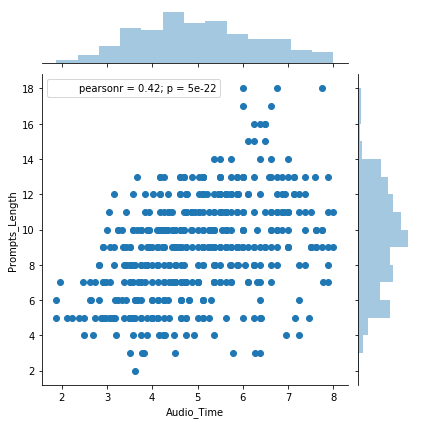

In [53]:
#Joint plot of the variables
sns.jointplot(x="Audio_Time",y="Prompts_Length",data=Database)

From above we see that the correlation is 0.42 which does not signify strong relation between the variables. From the graph it becomes clear that it is not necessary that longer audio time signifies more words or vice-versa.

In [54]:
#Time requried by the query
start = time.time()
Database["Audio_Time"].corr(Database["Prompts_Length"])
print ("Time requried by the query is" + " " + str(time.time() - start) + " secs")

Time requried by the query is 0.0007750988006591797 secs


### Database Query 4

Question: Now we will add predicted text to our database and try to compare the effeniency at character level and word level. Since our model is not prepared now, we will generate random text to replicate the scenerio when we will have predicted text and calculate the accuracies.

In [55]:
#function to generate random words 
def scramble(word):
    foo = list(word)
    random.shuffle(foo)
    return ''.join(foo)

In [56]:
Predicted_Sentence = []
for prompts in Database["Audio_Prompt"]:
    Predicted_Sentence.append(scramble(prompts))

In [57]:
Database["Predicted_Sentence"] = Predicted_Sentence

In [58]:
Database.head(7)

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time,Audio_MFCC,Prompts_Length,Predicted_Sentence
0,ar-01.wav,Once there was a young rat named Arthur who ne...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.250,"[[-71.4027789207, 16.6506328869, 7.90910317203...",15,km oogd u htti.nprcAirnrhslc a nt am mhvonae ...
1,ar-02.wav,Whenever his friends asked him if he would lik...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375,"[[-67.8487102654, 5.48487660143, -6.8639734958...",14,e hdskwhuloeoie euhavh h s t dte r oeiten m f...
2,ar-03.wav,"he would only answer, ""I don't know;"" he would...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.500,"[[-56.1370403534, 0.917676509435, -22.61451455...",16,"ow' skr ne""no n wyol ,woe.ohtailtI;sytynu..."
3,ar-04.wav,He would always shirk making a choice. His Aun...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.875,"[[-64.2758692913, 4.54850120146, -18.806625193...",13,"Hse,clwtH mliuihs Hoaitd nnenaumc A.a iils ..."
4,ar-05.wav,"""Now look here! No one is going to care for yo...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.625,"[[-42.9130282419, 18.4081023001, 12.3510009152...",17,"hri ia su! o ouw lnof""ekyh inccoo iiNregse y.t..."
5,ar-06.wav,You have no more mind than a blade of grass.,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,4.500,"[[-45.2064146321, 19.3503254482, 8.54280094932...",10,d ostYnedloanagi .mbm a a uaoe ovsh frr hn e
6,ar-07.wav,One rainy day the rats heard a great noise in ...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375,"[[-75.041533707, 0.761466980756, -5.1607832218...",12,n nsrhaeo e stnoeaidiOirhda hyta trl e.ytnrag...


Since we have not encoded our data (Audio Prompts and Predicted Sentence), and not decided the accuracy matrix we are not ready to write this query. But as part of our final project we will be implementing it.

### Database Query 5

Question: Find the distribution of Prompt Length and see number the highest occuring frequency of words.

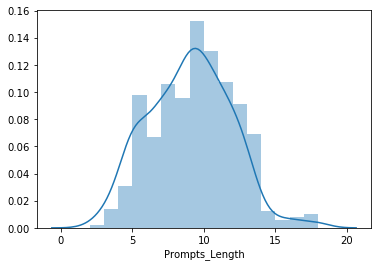

In [66]:
sns.distplot(Database.Prompts_Length)

The highest occuring frequency looks to be around 10 words. Let's more closely identify where exactly does the highest occouring frequency lies.

In [67]:
Database.groupby(pd.cut(Database['Prompts_Length'], np.arange(0,20,2))).count()

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time,Audio_MFCC,Prompts_Length,Predicted_Sentence
Prompts_Length,,,,,,,
"(0, 2]",1,1,1,1,1,1,1
"(2, 4]",22,22,22,22,22,22,22
"(4, 6]",81,81,81,81,81,81,81
"(6, 8]",99,99,99,99,99,99,99
"(8, 10]",139,139,139,139,139,139,139
"(10, 12]",98,98,98,98,98,98,98
"(12, 14]",40,40,40,40,40,40,40
"(14, 16]",7,7,7,7,7,7,7
"(16, 18]",5,5,5,5,5,5,5


8-10 words has the highest occouring frequency. Let's time the code snippet.

In [68]:
#Time requried by the query
start = time.time()
Database.groupby(pd.cut(Database['Prompts_Length'], np.arange(0,20,2))).count()
print ("Time requried by the query is" + " " + str(time.time() - start) + " secs")

Time requried by the query is 0.009274005889892578 secs


### Part -3 Building Automation Pipeline

For automating at this point of time we are building a function which accepts a new audio file as input and adds all the attributes of the audio file to the database.

How does this pipeline works:

* This is a function which takes location of the audio file and unprocessed audio prompt as input and generates a new row in database (i.e. the pandas dataframe) with all the values for that audio file as in the database above.

* Since at this moment the predicted_sentece is just randomly integrated, that's how the pipeline will work for this assignment. But for future we will be using Airflow to integrate the pipeline end to end from capturing input from the filesystem and all the preprocessing as well as the predicted output will be generated in a automated fashion.

In [59]:
#Always use desktop as the current working directory for the purpose of this assignment. Data folder on desktop will act 
# as file system (HDFS or something like that)
str(os.getcwd())

'/Users/Gurtej/Desktop'

Let's say we know the location of audio file on the file system and we have the corrosponding prompt to it.

Audio_Path: (str(os.getcwd()) + "/Data_Part_Project/pierrep-20110607-cos/wav/a0464.wav")
Audio_Prompt: a0464 Between the rush of the cascades, streaks of rust showed everywhere.

In [60]:
#audio input should be of type str(os.getcwd()) + directory of audio file 

#Function foe calculating MFCCs for audio files as described above
def mfcc(audio_path):

    sample_rate, signal = scipy.io.wavfile.read(audio_path)  # File assumed to be in the same directory
    signal = signal[0:int(8 * sample_rate)]  # Keep the first 3.5 seconds

    pre_emphasis = 0.97

    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    frame_size = 0.025
    frame_stride = 0.01

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]

    frames *= numpy.hamming(frame_length)

    NFFT = 512

    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    nfilt = 40 

    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB

    num_ceps = 12

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps + 1)] # Keep 2-13
    
    return mfcc

#Function to calculate audio length
def audio_length(audio_path):
    with contextlib.closing(wave.open(audio_path,'r')) as f: 
        frames = f.getnframes()
        rate = f.getframerate()
        length = frames / float(rate)    
        return length


def prompts_length(audio_prompts):
    tokenizer = RegexpTokenizer(r'\w+')
    text = audio_prompts
    tokens = tokenizer.tokenize(text)
    promp_length = len(tokens)
    return promp_length

#This is acting as our deep learning model now, just generating random words for input string
def scramble(word):
    foo = list(word)
    random.shuffle(foo)
    return ''.join(foo)   

In [61]:
def end_to_pipeline(audio_path, audio_prompt):
    
    Attributes = []
    
    Audio_ID = audio_path.split("/")
    Audio_ID = Audio_ID[-1]
    
    audio_prompt = audio_prompt.strip("\n") #removing "\n" from the audio files
    audio_prompt = audio_prompt.split(" ", 1)[1] #removing the audio_id from front of the prompt
    
    Audio_Prompt = audio_prompt
    
    Audio_Path = audio_path
    
    Audio_Time = audio_length(audio_path)
    
    Audio_MFCC = mfcc(audio_path)
    
    Prompt_Length = prompts_length(audio_prompt) #The argument for the prompt is the argument after processing the prompt
    
    Predicted_Sentence = scramble(Audio_Prompt)
    
    Attributes = [{"Audio_ID":Audio_ID, "Audio_Prompt":Audio_Prompt, "Audio_Path":Audio_Path, 
                               "Audio_Time": Audio_Time, "Audio_MFCC":Audio_MFCC, "Prompts_Length":Prompt_Length, 
                               "Predicted_Sentence":Predicted_Sentence}]
    
    
    return Database.append(Attributes, ignore_index=False)  #Automatically adding all the attributes for the new wav file to the dataframe
    


Let's now try to use our end to end pipeline finction and let's input a random audio file and its prompt and we'll see if our dataframe is extended. Before doing that let's check what is the currenct size of our database.

In [62]:
Database.shape


(491, 7)

In [63]:
#Calling the end_to_pipeline function on a new audio file and associated prompt
Database = end_to_pipeline((str(os.getcwd()) + "/Data_Part_Project/pierrep-20110607-cos/wav/a0464.wav"),"a0464 Between the rush of the cascades, streaks of rust showed everywhere.")

In [64]:
Database.shape

(492, 7)

We see that the new row has been added and the database has been updated. 

In [65]:
Database

,Audio_ID,Audio_Prompt,Audio_Path,Audio_Time,Audio_MFCC,Prompts_Length,Predicted_Sentence
0,ar-01.wav,Once there was a young rat named Arthur who ne...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.250000,"[[-71.4027789207, 16.6506328869, 7.90910317203...",15,km oogd u htti.nprcAirnrhslc a nt am mhvonae ...
1,ar-02.wav,Whenever his friends asked him if he would lik...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375000,"[[-67.8487102654, 5.48487660143, -6.8639734958...",14,e hdskwhuloeoie euhavh h s t dte r oeiten m f...
2,ar-03.wav,"he would only answer, ""I don't know;"" he would...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.500000,"[[-56.1370403534, 0.917676509435, -22.61451455...",16,"ow' skr ne""no n wyol ,woe.ohtailtI;sytynu..."
3,ar-04.wav,He would always shirk making a choice. His Aun...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.875000,"[[-64.2758692913, 4.54850120146, -18.806625193...",13,"Hse,clwtH mliuihs Hoaitd nnenaumc A.a iils ..."
4,ar-05.wav,"""Now look here! No one is going to care for yo...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.625000,"[[-42.9130282419, 18.4081023001, 12.3510009152...",17,"hri ia su! o ouw lnof""ekyh inccoo iiNregse y.t..."
5,ar-06.wav,You have no more mind than a blade of grass.,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,4.500000,"[[-45.2064146321, 19.3503254482, 8.54280094932...",10,d ostYnedloanagi .mbm a a uaoe ovsh frr hn e
6,ar-07.wav,One rainy day the rats heard a great noise in ...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.375000,"[[-75.041533707, 0.761466980756, -5.1607832218...",12,n nsrhaeo e stnoeaidiOirhda hyta trl e.ytnrag...
7,rp-29.wav,since red and green light when mixed form yell...,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,5.125000,"[[-80.9845757777, -4.08334894332, -5.545150627...",9,wnn lten eexodmlemngg shie efdr h rli cedory...
8,rp-30.wav,"This is a very common type of bow, one showing...",/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,6.375000,"[[-88.5948065033, 2.65618120525, -5.0680950417...",14,"tmh fyTm,w neno y wlylboro psiilmir a yd ha..."
9,rp-31.wav,with little or no green or blue.,/Users/Gurtej/Desktop/Data_Part_Project/1028-2...,4.125000,"[[-52.9773057292, 15.9028896585, 0.18626564272...",7,r.ibo ngw etltotorleur eh einl


Towards the bottom we see a new row has been added and database has been updated

### Part -4 Taking the backup of Data

I am just exporting a csv file to create backup of my data. Csv file would be attached with the submission.

In [72]:
os.getcwd()+"/Database.csv"

'/Users/Gurtej/DesktopDatabase.csv'

In [73]:
Database.to_csv(os.getcwd()+"/Database.csv")